In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
# from featureranker import view_data
# from featureranker import classification_hyper_param_search
# from featureranker import classification_ranking
# from featureranker import voting
# from featureranker import plot_ranking


import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
# import pycuda.autoinit
# import pycuda.gpuarray as gpuarray
pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()
torch.cuda.empty_cache()

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install pybaseball

In [3]:
!pip install --upgrade scikit-learn imbalanced-learn

In [4]:
!pip install featureranker

In [5]:
import os
import sys

# Check if the code is running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    save_path='/content/drive/My Drive/baseball_pred/pybaseball_v3_saved'
    #Vegas Odds path
    vegas_betting_paths='/content/drive/My Drive/baseball_pred/betting_odds/'
    vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

    #Scrambled Odds path
    scrambled_betting_paths='/content/drive/My Drive/baseball_pred/all_money_lines.csv'


    #Per_game_data path
    per_game_path='/content/drive/My Drive/baseball_pred/pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



    milb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
    milb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
    mlb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
    mlb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
    scoring_full_all_years='/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl'
    scoring_save_path='/content/drive/My Drive/baseball_pred/scoring_milb.pkl'
    def save_results_format(year):
      save_results=f'/content/drive/My Drive/baseball_pred/results/better_data_{year}.xlsx'
      return save_results
else:
    # Code to run if not in Google Colab
    # For example, set a local path for your files if on a local machine
    # local_drive_path = 'd:/Users/vile3/Google Drive'
    # if not os.path.exists(local_drive_path):
        # os.makedirs(local_drive_path)
        save_path='pybaseball_v3_saved'
        vegas_betting_paths='./betting_odds/'
        vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

        #Scrambled Odds path
        scrambled_betting_paths='all_money_lines.csv'


        #Per_game_data path
        per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



        milb_batter_path = './SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
        milb_pitcher_path = './SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
        mlb_batter_path = './SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
        mlb_pitcher_path = './SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
        scoring_full_all_years='scoring_full_all_years.pkl'
        scoring_save_path='scoring_milb.pkl'
        def save_results_format(year):
          save_results=f'./results/better_data_{year}.xlsx'
          return save_results
    # Now you can use local_drive_path as the base path for your file operations


# Functions

In [6]:
# Check if CUDA is available

# Move your model to the GPU
# model = model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# When you load your data, move it to the GPU
# Assume inputs and labels are your input data and labels
# inputs, labels = inputs.to(device), labels.to(device)


# Neural Network

In [7]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_size) for _ in range(hidden_num + 1)])
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norms[0](x)
        x = self.gelu(x)
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.hidden_layers[i](x)
            x = self.batch_norms[i + 1](x)
            x = self.gelu(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data
        X_train, X_valid = X[train_indices], X[valid_indices]
        y_train, y_valid = y[train_indices], y[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model
    # global label1,label2, label3, label4, label5, label6,model1, model2, model3, model_all
    alpha=0.01
    for param in model.parameters():
        model_all=(param.device)
    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            # label1=(inputs.device)
            # label2=(labels.device)
            # model1=(next(model.parameters()).device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + alpha * l1_norm
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:  # Use validation data for validation
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
                # label3=(inputs.device)
                # label4=(labels.device)
                # model2=(next(model.parameters()).device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())

                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    # model.load_state_dict(torch.load(best_model_path))
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use test data for final evaluation
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            # label5=(inputs.device)
            # label6=(labels.device)
            # model3=(next(model.parameters()).device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,output_dict=True)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

import os

def save_to_path(df, filename, folder=save_path):
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, f'{filename}.csv')

    if os.path.exists(path):
        print(f'File {path} already exists.')
    else:
        df.to_csv(path, index=True)
        print(f'{filename} saved to {path}')

def process_per_game_data(per_game_data, columns_to_keep, train_years):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_Number'] = per_game_data.groupby(['Date', 'HmTm', 'VisTm']).cumcount() + 1
    per_game_data['Game_ID'] = (
        per_game_data['Date'].astype(str) +
        per_game_data['HmTm'] +
        per_game_data['VisTm'] +
        per_game_data['Game_Number'].astype(str)
    )
    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()
    # Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]
    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)

    # Truncate rows based on the lowest train year
    lowest_train_year = min(train_years)
    per_game_data = per_game_data[per_game_data.index.str[:4] >= lowest_train_year]

    return per_game_data

def process_vegas_odds(paths):

    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_Number'] = xlsx_dataframes.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    xlsx_dataframes['Game_ID'] = (
        xlsx_dataframes['date'].astype(str) +
        xlsx_dataframes['home_team'] +
        xlsx_dataframes['visiting_team'] +
        xlsx_dataframes['Game_Number'].astype(str)
    )

    xlsx_dataframes.set_index('Game_ID', inplace=True)

    xlsx_dataframes.drop(['Game_Number','date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes

import time
from requests.exceptions import RequestException

def fetch_data_with_retry(fetch_func, data_type, max_retries=5, retry_delay=3):
    retries = 0
    while retries < max_retries:
        try:
            data = fetch_func(True)
            print(f"{data_type} data fetched successfully.")
            return data
        except RequestException as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}. Retrying after {retry_delay} seconds...")
            time.sleep(retry_delay)
            retry_delay *= 2  # Exponential backoff
    print(f"Failed to fetch {data_type} data after {max_retries} attempts.")
    return None

def process_scrambled_odds(df):
    df['Game_Number'] = df.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    df['Game_ID'] = (
        df['date'].astype(str) +
        df['home_team'] +
        df['visiting_team'] +
        df['Game_Number'].astype(str)
    )

    df.set_index('Game_ID', inplace=True)

    # Fix: Correct the drop method usage by specifying the column indices correctly
    columns_to_drop = df.columns[[0, 1]]
    print("Dropping columns:", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    return df

def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]
def weighted_average(group, weights):
    return pd.Series(
        {col: np.average(group[col], weights=weights.loc[group.index]) for col in group.columns}
    )
def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
    # Calculate averages
    player_avg = player_data.groupby(player_data.index).mean()
 


# Continue with the rest of your code...

    # Create a dictionary for each stat
    stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

    for column in player_id_columns:
        # Replace the player_IDs in the column with the stats
        for stat, stat_dict in stat_dicts.items():
            per_game_data[column + '_' + stat] = per_game_data[column].map(stat_dict)

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    return per_game_data




def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

def remove_excess_player_columns(player_data,columns_to_remove):
    player_data = player_data.drop(columns=columns_to_remove)
    return player_data

def split_data(per_game_data_reduced, train_year, test_year):
    # Create a mask for the training set
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

    # Split the data into training and testing sets
    X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)

    # X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)

    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)

    # X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']

    return X_train, y_train, X_test, y_test


def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.eval()
    # model.to(device)  # Move your model to the GPU
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float).to(device)
            # game_vector = torch.tensor([game_data[i]], dtype=torch.float)

            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped, prob



def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method, fill_value=0)
    # Fit and transform all columns
    df[:] = imputer.fit_transform(df)
    return df

# def Impute(df, method):
#     # Create an imputer instance
#     imputer = SimpleImputer(strategy=method)
#     # Fit and transform all columns
#     imputed_data = imputer.fit_transform(df)
#     # Create a new DataFrame with the same index and columns as the original
#     new_df = pd.DataFrame(imputed_data, index=df.index, columns=df.columns)
#     return new_df

# def Impute(df, method):
#     # Create an imputer instance
#     imputer = SimpleImputer(strategy=method, add_indicator=True)  # add_indicator will add a binary column indicating the presence of missing values
#     # Fit and transform all columns
#     imputed_data = imputer.fit_transform(df)
#     # The imputer might add additional columns to indicate the presence of missing values
#     new_columns = list(df.columns) + [f"{col}_missing_flag" for col in df.columns[imputer.indicator_.features_]]
#     # Create a new DataFrame with the same index and the new columns
#     new_df = pd.DataFrame(imputed_data, index=df.index, columns=new_columns)
#     return new_df

class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance
        self.bet_history = []
    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data, prob, augment=False, scaler=1):
        # Ensure the bettor has enough money in the wallet
        amount_bet = max(self.wallet * 0.01, 10)
        amount_bet = amount_bet * prob * scaler if augment else amount_bet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]

        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]

        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']

            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds

            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)

            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)
            self.bet_history.append(amount_bet)
        return self.wallet

def combine_odds(per_game_data, vegas_odds, scrambled_odds):
    # Merge vegas_odds and scrambled_odds into per_game_data
    per_game_data = per_game_data.merge(vegas_odds, how='left', left_index=True, right_index=True)
    per_game_data = per_game_data.merge(scrambled_odds, how='left', left_index=True, right_index=True, suffixes=('_vegas', '_scrambled'))

    # Create new columns 'home_odds' and 'visiting_odds' where vegas_odds takes precedence
    per_game_data['home_odds'] = per_game_data['home_open_vegas'].combine_first(per_game_data['home_open_scrambled'])
    per_game_data['visiting_odds'] = per_game_data['visiting_open_vegas'].combine_first(per_game_data['visiting_open_scrambled'])

    # Fill any remaining NaNs with -110
    per_game_data['home_odds'].fillna(-110, inplace=True)
    per_game_data['visiting_odds'].fillna(-110, inplace=True)

    # Drop the original odds columns
    per_game_data.drop(columns=['home_open_vegas', 'visiting_open_vegas', 'home_open_scrambled', 'visiting_open_scrambled'], inplace=True)

    # Reset the index before returning


    # return per_game_data[['home_odds', 'visiting_odds']]
    return per_game_data

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import copy

from sklearn.metrics import accuracy_score

def permutation_importance(model, loader, criterion, metric):
    model.eval()
    original_score = metric(model, loader, criterion)
    importances = []
    for i in range(loader.dataset.X.size(1)):  # Assuming 'X' is the attribute storing your input data
        temp = loader.dataset.X.clone()
        temp[:, i] = torch.randperm(temp.size(0))
        temp_dataset = vector_dataset(temp, loader.dataset.y)  # Assuming 'y' is the attribute storing your labels
        temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
        score = metric(model, temp_loader, criterion)
        importances.append(original_score - score)
    return importances


def automated_feature_selection(model, train_loader, val_loader, test_loader, optimizer, criterion, metric, patience=5, num_epochs=50):
    best_score = 0
    best_model = None
    important_features = list(range(len(train_loader.dataset[0][0])))
    while len(important_features) > 0:
        # Train the model
        conf_matrix, class_report = train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience, num_epochs)
        # Calculate the score
        score = class_report['accuracy']  # Assuming class_report is a dictionary with 'accuracy' key
        # If the score has improved, update the best score and best model
        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(model)
        else:
            # If the score has not improved, add the last removed feature back and break the loop
            important_features.append(last_removed_feature)
            break
        # Calculate the permutation importance
        importances = permutation_importance(model, val_loader.dataset.tensors[0][:, important_features], val_loader.dataset.tensors[1], metric)
        # Remove the least important feature
        last_removed_feature = important_features.pop(np.argmin(importances))
    return best_model, important_features
# usage

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer
import pandas as pd

def scale_data(X_train, X_test, method='minmax'):
    """
    Scales the training and test dataframes using various scaling methods.

    Parameters:
    - X_train: Training data as a pandas DataFrame.
    - X_test: Test data as a pandas DataFrame.
    - method: The scaling method to use ('minmax', 'standard', 'robust', 'normalizer', 'maxabs', 'power', 'quantile').

    Returns:
    - X_train_scaled: Scaled training data as a pandas DataFrame.
    - X_test_scaled: Scaled test data as a pandas DataFrame.
    """
    scalers = {
        'minmax': MinMaxScaler(),
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'normalizer': Normalizer(),
        'maxabs': MaxAbsScaler(),
        'power': PowerTransformer(),
        'quantile': QuantileTransformer(output_distribution='normal')
    }

    if method not in scalers:
        raise ValueError(f"Method should be one of {list(scalers.keys())}")

    scaler = scalers[method]

    # Fit on training set only.
    scaler.fit(X_train.values)

    # Apply transform to both the training set and the test set.
    X_train_scaled = pd.DataFrame(scaler.transform(X_train.values), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

    return X_train_scaled, X_test_scaled

#

# Import Data

In [8]:
test_year = '2023'
train_years = [str(year) for year in range(int(test_year) - 8, int(test_year))]


milb_batter = pd.read_csv(milb_batter_path)
milb_pitcher = pd.read_csv(milb_pitcher_path)
#betting data site
scrambled_odds_full=pd.read_csv(scrambled_betting_paths)
#People Import
chad_v3 = pyb.chadwick_register()

#Vegas Odds Import and process in one
vegas_odds=process_vegas_odds(vegas_paths)

#batter imports full data
batter_data = pd.read_csv(mlb_batter_path)
#pitcher imports full data
pitcher_data = pd.read_csv(mlb_pitcher_path)


#per game data full data
per_game_data_full = pd.read_csv(per_game_path, header=0)



#Drops all columns except for the columns below
columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns','HmTm','VisTm']
per_game_data = process_per_game_data(per_game_data_full, columns_to_keep,train_years)
# per_game_players = add_players_to_games()


                 home_open  visiting_open
Game_ID                                  
20100404BOSNYY1       -114           -106
20100405WASPHI1        170           -200
20100405NYMMIA1       -115           -105
20100405CINSTL1        135           -155
20100405PITLOS1        135           -155
...                    ...            ...
20211027HOUATL1       -115           -105
20211029ATLHOU1       -115           -105
20211030ATLHOU1       -115           -105
20211031ATLHOU1       -105           -115
20211102HOUATL1       -120            100

[28006 rows x 2 columns]


In [9]:
batter_columns = set(batter_data.columns)
pitcher_columns = set(pitcher_data.columns)
milb_batter_columns = set(milb_batter.columns)
milb_pitcher_columns = set(milb_pitcher.columns)

common_batter_columns = batter_columns.intersection(milb_batter_columns)
common_pitcher_columns = pitcher_columns.intersection(milb_pitcher_columns)

missing_batter_columns = batter_columns.difference(milb_batter_columns)
missing_pitcher_columns = pitcher_columns.difference(milb_pitcher_columns)

print("Common columns in batter and milb_batter data: ", common_batter_columns)
print("Common columns in pitcher and milb_pitcher data: ", common_pitcher_columns)
print("Columns in batter data but missing in milb_batter data: ", missing_batter_columns)
print("Columns in pitcher data but missing in milb_pitcher data: ", missing_pitcher_columns)


Common columns in batter and milb_batter data:  {'G', 'Pitches', 'R', 'HR', '3B', 'Balls', 'Age', 'RBI', '1B', 'ISO', 'SB', 'HR/FB', 'Pull%', 'LD%', 'BB', 'SO', 'wRC+', 'Oppo%', 'Team', 'BB%', 'CS', 'IFFB%', 'IBB', 'PA', 'HBP', 'wRAA', 'OPS', 'TeamName', 'SF', 'AB', 'OBP', 'wOBA', 'GB/FB', 'H', 'BB/K', 'K%', 'Season', 'Strikes', 'Spd', 'SH', 'Name', 'SwStr%', 'wBsR', 'wRC', 'SLG', 'FB%', 'GB%', '2B', 'GDP', 'PlayerName', 'AVG', 'BABIP', 'Cent%'}
Common columns in pitcher and milb_pitcher data:  {'LOB%', 'G', 'WHIP', 'Pitches', 'R', 'HR', 'E-F', 'Balls', 'W', 'GS', 'FIP', 'Age', 'BK', 'BB/9', 'ER', 'HR/FB', 'SV', 'Pull%', 'LD%', 'BB', 'SO', 'K/9', 'Oppo%', 'Team', 'K-BB%', 'BB%', 'IFFB%', 'IP', 'WP', 'IBB', 'HBP', 'BS', 'TeamName', 'ERA', 'xFIP', 'GB/FB', 'H', 'Season', 'K%', 'Strikes', 'Name', 'SwStr%', 'L', 'FB%', 'TBF', 'GB%', 'PlayerName', 'K/BB', 'AVG', 'BABIP', 'Cent%', 'HR/9', 'CG', 'ShO'}
Columns in batter data but missing in milb_batter data:  {'pfxwFO', 'pfxwFA/C', 'SFv', 'KN%

In [10]:

#process scrambled odds
scrambled_odds=process_scrambled_odds(scrambled_odds_full)





#save it to a folder called pybaseball_v3_saved
save_to_path(per_game_data_full, 'per_game_data_full')
save_to_path(per_game_data, 'per_game_data')
save_to_path(batter_data, 'batter_bwar_data')
save_to_path(pitcher_data, 'pitcher_bwar_data')
save_to_path(chad_v3,'chad_v3')
save_to_path(vegas_odds,'vegas_odds')
save_to_path(scrambled_odds,'scrambled_odds')
save_to_path(scrambled_odds_full,'scrambled_odds_full')



pitcher_names = pyb.playerid_reverse_lookup(pitcher_data['playerid'], key_type='fangraphs')
batter_names = pyb.playerid_reverse_lookup(batter_data['playerid'], key_type='fangraphs')
#For some reason the chad data is missing
batter_data = batter_data[batter_data['playerid'] != 'stantha01']

# Create a mapping from player_ID to key_retro for pitchers and batters
pitcher_id_to_retro = pitcher_names.set_index('key_fangraphs')['key_retro'].to_dict()
batter_id_to_retro = batter_names.set_index('key_fangraphs')['key_retro'].to_dict()

# Replace player_ID with key_retro in pitcher_data and batter_data
pitcher_data['playerid'] = pitcher_data['playerid'].map(pitcher_id_to_retro)
batter_data['playerid'] = batter_data['playerid'].map(batter_id_to_retro)



# batter_data.drop(['name_common','mlb_ID','pitcher','year_ID','salary','PA'], axis=1, inplace=True)
# pitcher_data.drop(['name_common','mlb_ID','RpO_replacement','salary','year_ID'], axis=1, inplace=True)
# batter_data.drop(['name_common','mlb_ID','year_ID'], axis=1, inplace=True)
# pitcher_data.drop(['name_common','mlb_ID','year_ID'], axis=1, inplace=True)
# batter_data.drop(batter_data.columns[0],axis=1,inplace=True)
# pitcher_data.drop(pitcher_data.columns[0],axis=1,inplace=True)

# pitcher_data=remove_columns_with_nan(pitcher_data,80)
# batter_data=remove_columns_with_nan(batter_data,80)

batter_data.set_index('playerid', inplace=True)
pitcher_data.set_index('playerid', inplace=True)


pitcher_encoded=label_encode(pitcher_data)
batter_encoded=label_encode(batter_data)

# Calculate averages
pitcher_avg = pitcher_data.groupby('playerid').mean()
batter_avg = batter_data.groupby('playerid').mean()

# #map player_ids to per_game_data
pitcher_stats_dict = pitcher_avg.to_dict('index')
batter_stats_dict = batter_avg.to_dict('index')


per_game_data_odds = combine_odds(per_game_data, vegas_odds, scrambled_odds)



pitcher_columns = ['HmStPchID', 'VisStPchID']
batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

# Replace the player_IDs with stats
per_game_finished = replace_player_ids_with_stats(per_game_data_odds, pitcher_data, pitcher_columns)
per_game_finished = replace_player_ids_with_stats(per_game_data_odds, batter_data, batter_columns)
aaaaaaa = per_game_finished
per_game_finished = label_encode(per_game_finished)
view_data(per_game_finished)
per_game_finished=remove_columns_with_nan(per_game_finished,40)
per_game_finished=Impute(per_game_finished,'mean')


# per_game_finished.drop(['home_team','visiting_team','Game_Number'], axis=1, inplace=True)
per_game_finished.drop(['home_team','visiting_team'], axis=1, inplace=True)




# remove_columns = ['mlb_ID']
# pitcher_removed=remove_excess_player_columns(pitcher_data,remove_columns)
# batter_removed=remove_excess_player_columns(batter_data,remove_columns)

X_train, y_train, X_test, y_test = split_data(per_game_finished, train_years, test_year)
# Assume X_train and X_test are your input data



# Choose scaling method.
# X_train, X_test = scale_data(X_train, X_test, method='minmax')

X_train, X_test = scale_data(X_train, X_test, method='standard')





# Move your model to the specified device

# Split the original training data into new training data and validation data
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_val_tensor = torch.from_numpy(X_val.values).float()
# y_val_tensor = torch.from_numpy(y_val.values).long()
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)
from imblearn.under_sampling import RandomUnderSampler

# Assume X and y are your input data and labels


# val_dataset = vector_dataset(X_val_tensor, y_val_tensor)
# train_dataset = vector_dataset(X_train_new, y_train_new)
# test_dataset = vector_dataset(X_test, y_test)

# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




# Move your model to the specified device

# When you iterate over your DataLoader, move each batch to the GPU


# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion = nn.CrossEntropyLoss()


# X_train_new=gpuarray.to_gpu(X_train_new)
# y_train_new=gpuarray.to_gpu(y_train_new)
# Assuming 'target' is the name of your target variable




# hypers = classification_hyper_param_search(X_small, y_small)  # For classification tasks
# # or
# hypers = regression_hyper_param_search(X_small, y_small, 3, 5)  # For regression tasks
# xb_hypers = hypers[0]['best_params']
# rf_hypers = hypers[1]['best_params']
X,y=get_data(per_game_finished, labels='winner')
# X_small, _, y_small, _ = train_test_split(X_train_new, y_train_new, test_size=0.01, random_state=42)  # Use 10% of the data
_, X_small, _, y_small = train_test_split(X, y, test_size=0.05, random_state=42)  # Use 10% of the data
rankings = classification_ranking(X_small, y_small, predict=True, choices=['mi', 'f_test'])  # For classification tasks
# # or
# # #   ranking = regression_ranking(X_small, y_small, rf_hypers, xb_hypers)  # For regression tasks

scoring = voting(rankings)
# plot_after_vote(scoring, title='Feature Ranking')
# Assuming scoring is a list of tuples and you want to normalize the second element of each tuple
scores = [score[1] for score in scoring]  # Extract the second element from each tuple
min_score = min(scores)
max_score = max(scores)
scoring = [(item[0], (item[1] - min_score) / (max_score - min_score)) for item in scoring]

import pickle

with open('fangraphs_scoring', 'wb') as f:
    pickle.dump(scoring, f)


import pickle

with open('fangraphs_scoring', 'rb') as f:
    scoring = pickle.load(f)

threshold=0.5
# Get the list of columns to keep
# Convert `scoring` into a DataFrame
scoring_df = pd.DataFrame(scoring, columns=['column_name', 'score'])

# Filter the columns to keep
columns_to_keep = scoring_df[scoring_df['score'] > threshold]['column_name'].tolist()

# Ensure that only columns that exist in the DataFrame are kept
columns_to_keep = [col for col in columns_to_keep if col in X_train_new.columns]
# X_val_new=X_val
# X_test_new=X_test
X_train_new = X_train_new[columns_to_keep]
X_val_new = X_val[columns_to_keep]
X_test_new = X_test[columns_to_keep]

# Ensure 'HmRuns' and 'VisRuns' are in the list of columns to keep
# columns_to_keep = set(columns_to_keep) | {'HmRuns', 'VisRuns'}

# # Filter the DataFrames to only include the desired columns
# X_train_new = X_train_new[list(columns_to_keep & set(X_train_new.columns))]
# X_val_new = X_val[list(columns_to_keep & set(X_val.columns))]
# X_test_new = X_test[list(columns_to_keep & set(X_test.columns))]



# y_train_new['index']=y_train_new.index

X_train_new['game_index']=X_train_new.index

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_new, y_train_new)
# X_train_res=X_train_new
# y_train_res=y_train_new
# Assuming `vector_dataset` is a class that converts your data into a format suitable for PyTorch
# y_train_new.set_index('index',inplace=True)
X_train_res.set_index('game_index',inplace=True)


# Create a new model with the updated number of features

# Create new DataLoaders with the updated datasets
train_dataset_new = vector_dataset(X_train_res, y_train_res)
val_dataset_new = vector_dataset(X_val_new, y_val)
test_dataset_new = vector_dataset(X_test_new, y_test)

train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=64, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)


num_runs = 3
conf_matrices = []
class_reports = []


# Now you can train this model with the dropped datasets
for _ in range(num_runs):
    # Reinitialize the model for each run
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
    model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15).to(device)
    # model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15)

# When you iterate over your DataLoader, move each batch to the GPU
    # model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    # L2 regularization with weight_decay
    # optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=6e-3)
    criterion = nn.CrossEntropyLoss()

    conf_matrix, class_report = train_and_evaluate_model(model, train_loader_new, val_loader_new, test_loader_new, optimizer, criterion)
    # conf_matrix, class_report = train_and_evaluate_model(model, train_loader,val_loader, test_loader, optimizer, criterion)
    conf_matrices.append(conf_matrix)
    class_reports.append(pd.DataFrame(class_report).transpose())

 #Average the confusion matrices
avg_conf_matrix = sum(conf_matrices) / num_runs

# Average the classification reports
avg_class_report = pd.concat(class_reports).groupby(level=0).mean()

print('Average Confusion Matrix:')
print(avg_conf_matrix)
print('Average Classification Report:')
print(avg_class_report)



prob = None
ok, bets, skipped, prob = predict_game_outcome(X_test_new.index, X_test_new.values, model, False, 10, 1)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)

for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, prob, True, 3)
# Create a new model with the updated number of features


Dropping columns: Index(['date', 'GameId'], dtype='object')
File pybaseball_v3_saved\per_game_data_full.csv already exists.
File pybaseball_v3_saved\per_game_data.csv already exists.
File pybaseball_v3_saved\batter_bwar_data.csv already exists.
File pybaseball_v3_saved\pitcher_bwar_data.csv already exists.
File pybaseball_v3_saved\chad_v3.csv already exists.
File pybaseball_v3_saved\vegas_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds_full.csv already exists.
The column Game_Number has 68.6% NaN values.
The column HmStPchID_Throws has 0.1% NaN values.
The column HmStPchID_xMLBAMID has 0.1% NaN values.
The column HmStPchID_Name has 0.1% NaN values.
The column HmStPchID_Team has 0.1% NaN values.
The column HmStPchID_Season has 0.1% NaN values.
The column HmStPchID_Age has 0.1% NaN values.
The column HmStPchID_AgeR has 0.1% NaN values.
The column HmStPchID_SeasonMin has 0.1% NaN values.
The column HmStPchID_Seas

Epoch 1: 100%|██████████| 207/207 [00:06<00:00, 29.85it/s]


Training Loss: 630.5223969537855
Validation Loss: 0.7607567459344864


In [ ]:
print(X_test)

                     HmTm     VisTm  HmStPchID_Throws  HmStPchID_xMLBAMID  \
Game_ID                                                                     
20230330CHNMIL1 -0.981636  0.057357          0.631713            0.199203   
20230330CINPIT1 -0.866125  0.750676          0.631713            1.343031   
20230330LANARI1 -0.173065 -1.560388         -1.584057            0.862885   
20230330MIANYN1 -0.057555  0.404017          0.631713            1.060705   
20230330SDNCOL1  0.866525 -0.635962         -1.584057            0.585244   
...                   ...       ...               ...                 ...   
20231001CHASDN1 -1.097146  0.866230          0.631713            0.168675   
20231001DETCLE1 -0.519595 -0.751515         -1.584057            0.447488   
20231001KCANYA1 -0.288575  0.288464          0.631713           -1.561954   
20231001SEATEX1  0.982036  1.443996          0.631713            1.355486   
20231001TORTBA1  1.559586  1.328443          0.631713            1.011555   

In [ ]:
# Calculate the number of games won by the home team and the visiting team
home_wins = sum(per_game_data['winner'] == 1)
visitor_wins = sum(per_game_data['winner'] == 0)
total_games = len(per_game_data)

home_win_percentage = (home_wins / total_games) * 100
visitor_win_percentage = (visitor_wins / total_games) * 100

print(f"Number of games won by home team: {home_wins} ({home_win_percentage:.2f}%)")
print(f"Number of games won by visiting team: {visitor_wins} ({visitor_win_percentage:.2f}%)")

print(np.bincount(y_train_res))

Number of games won by home team: 10854 (53.38%)
Number of games won by visiting team: 9480 (46.62%)
[6597 6597]


In [ ]:
# Compare the bets in 'ok' to the 'winner' in 'per_game_data' to determine the number of correct game bets
# They are matched by the game_index
# Assuming 'winner' column is integer with 1 representing a win
# Assuming 'ok' is a list of tuples where the first element is the game_id as text
# and 'per_game_finished' has an index that corresponds to these game_ids
# Assuming 'ok' is a list of tuples where the first element is the game_id (which matches the index of per_game_finished)
# and the second element is the predicted winner (1 for home win, 0 for visitor win)
correct_bets = 0
for game_id, bet_on_home_team in ok:
    predicted_home_win = bet_on_home_team == 'True'  # Convert the string to a boolean
    actual_home_win = per_game_finished.loc[game_id, 'winner'] == 1  # Assuming 1 represents a home win
    if predicted_home_win == actual_home_win:
        correct_bets += 1

incorrect_bets = len(ok) - correct_bets
percentage_correct = (correct_bets / len(ok)) * 100

print(f"Number of correct game bets: {correct_bets}")
print(f"Number of incorrect game bets: {incorrect_bets}")
print(f"Percentage of correct bets: {percentage_correct:.2f}%")


Number of correct game bets: 1256
Number of incorrect game bets: 1174
Percentage of correct bets: 51.69%


In [ ]:
# import pickle

# # Load the first pickle file
# with open('/content/drive/My Drive/baseball_pred/scoring_full.pkl', 'rb') as f:
#     scoring_full = pickle.load(f)

# # Load the second pickle file
# with open('/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl', 'rb') as f:
#     scoring_full_all_years = pickle.load(f)

# # Convert both to DataFrames for easier comparison
# import pandas as pd
# df_scoring_full = pd.DataFrame(scoring_full, columns=['feature', 'score'])
# df_scoring_full_all_years = pd.DataFrame(scoring_full_all_years, columns=['feature', 'score'])

# # Merge the two DataFrames on the feature column
# merged_df = df_scoring_full.merge(df_scoring_full_all_years, on='feature', suffixes=('_full', '_all_years'))

# # Calculate the score differences
# merged_df['score_difference'] = merged_df['score_all_years'] - merged_df['score_full']

# # Filter out the features with a score difference greater than 10
# significant_differences = merged_df[abs(merged_df['score_difference']) > 10]

# # Display the features with significant score differences
# print(significant_differences)

In [ ]:
print(X_train)

                     HmTm     VisTm  HmStPchID_Throws  HmStPchID_xMLBAMID  \
Game_ID                                                                     
20150405CHNSLN1 -0.981636  1.212889         -1.584057           -1.241462   
20150406DETMIN1 -0.519595  0.172910         -1.584057           -1.201097   
20150406HOUCLE1 -0.404085 -0.751515         -1.584057            0.196633   
20150406KCACHA1 -0.288575 -1.098175          0.631713            0.168879   
20150406NYATOR1  0.288975  1.559549          0.631713           -0.103180   
...                   ...       ...               ...                 ...   
20221005CLEKCA1 -0.750615 -0.289303          0.631713            1.125047   
20221005HOUPHI1 -0.404085  0.635123         -1.584057            1.288096   
20221005OAKANA1  0.519995 -1.675941         -1.584057            1.554943   
20221005SEADET1  0.982036 -0.520409         -1.584057            0.457970   
20221005TEXNYA1  1.444076  0.288464          0.631713            1.203983   

In [ ]:
# def plot_wallet_balance(better):
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     color = 'tab:blue'
#     ax1.set_xlabel('Number of Games Bet')
#     ax1.set_ylabel('Wallet Balance', color=color)
#     ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     color = 'tab:red'
#     ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
#     ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.title('Wallet Balance and Bet Amount Over Number of Games Bet')
#     plt.grid(True)
#     plt.show()


import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_wallet_balance(better, year):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Games Bet')
    ax1.set_ylabel('Wallet Balance', color=color)
    ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    title = f'Wallet Balance and Bet Amount Over Number of Games Bet in {year}'
    plt.title(title)
    plt.grid(True)

    # Save the plot as an image
    if not os.path.exists('results'):
        os.makedirs('results')
    plt.savefig(f'results/{title}.png')

    plt.show()
    save_results=save_results_format(year)
    # Save the better data, avg_class_report, and avg_conf_matrix to an Excel file
    with pd.ExcelWriter(save_results) as writer:
        pd.DataFrame(better.wallet_history).to_excel(writer, sheet_name='wallet_history')
        pd.DataFrame(better.bet_history).to_excel(writer, sheet_name='bet_history')
        avg_class_report.to_excel(writer, sheet_name='avg_class_report')
        pd.DataFrame(avg_conf_matrix).to_excel(writer, sheet_name='avg_conf_matrix')

In [ ]:


# def plot_wallet_balance(better):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(len(better.wallet_history)), better.wallet_history)
#     plt.xlabel('Number of Games Bet')
#     plt.ylabel('Wallet Balance')
#     plt.title('Wallet Balance Over Number of Games Bet')
#     plt.grid(True)
#     plt.show()

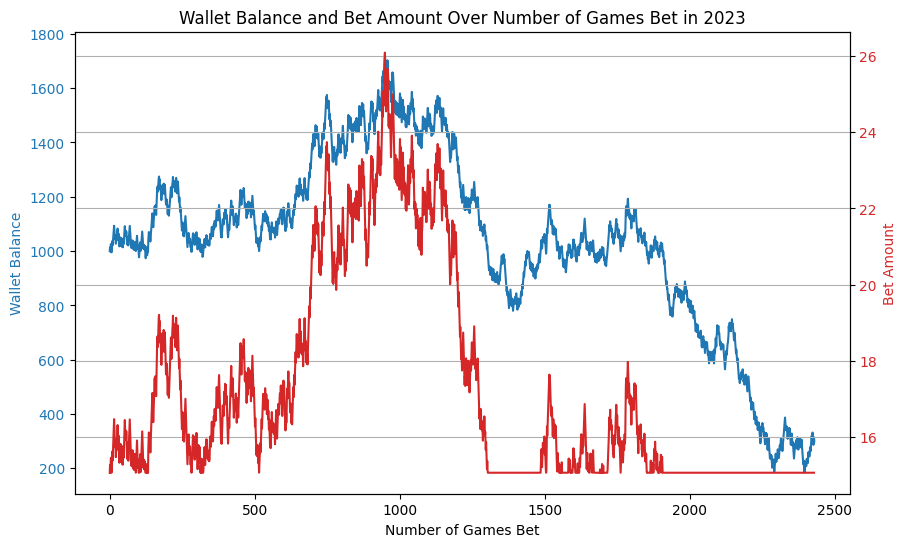

26.080915440316375
15.073649883270264
183.9693025533419
299.3570351429618


In [ ]:
plot_wallet_balance(better, test_year)
print(max(better.bet_history))
print(min(better.bet_history))
print(min(better.wallet_history))
print(better.wallet_history[-1])


In [ ]:
view_data(per_game_finished)

There are no NaN values in the dataset


In [ ]:
# view_data(pitcher_names)
view_data(batter_data)

The column Fielding has 24.5% NaN values.
The column CFraming has 87.7% NaN values.
The column phLI has 19.9% NaN values.
The column SL% has 0.7% NaN values.
The column SLv has 0.7% NaN values.
The column CT% has 4.9% NaN values.
The column CTv has 5.2% NaN values.
The column CB% has 0.6% NaN values.
The column CBv has 0.7% NaN values.
The column CH% has 3.2% NaN values.
The column CHv has 3.3% NaN values.
The column SF% has 20.7% NaN values.
The column SFv has 20.9% NaN values.
The column KN% has 59.1% NaN values.
The column KNv has 59.2% NaN values.
The column XX% has 28.1% NaN values.
The column PO% has 81.9% NaN values.
The column wSL has 0.7% NaN values.
The column wCT has 4.9% NaN values.
The column wCB has 0.6% NaN values.
The column wCH has 3.2% NaN values.
The column wSF has 20.7% NaN values.
The column wKN has 59.1% NaN values.
The column wSL/C has 0.7% NaN values.
The column wCT/C has 4.9% NaN values.
The column wCB/C has 0.6% NaN values.
The column wCH/C has 3.2% NaN values